## DSGE w. Feedback - Numerical Simulations

### Imports

In [3]:
%matplotlib notebook
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
import steadystate
import model

-----
# Steady State Effects of Parameter variations

In [6]:
kwargs = dict(gs_num=10, T=2e3, err=1e-4, 
              macro_vars=['c', 'n', 'b', 'k', 'q', 'w', 'utility'],
              params={'etaZ': 0.2, 'sigmaZ': 0.0, 'zbar': 1.0, 'sigmaN': 0.2, 
                      'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.04, 
                      'g_min': 0.9, 'g_max': 1-1e-4, 's_min': 0.5, 's_max': 1, 
                      'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
                      'gamma': 1.0, 'alpha': 0.33, 'mu': 0.32}, 
              start_dict=dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.0, g=0.7, s=0.5, income=1, news=1, xiz=0, xin=0))

In [7]:
ss_mu = steadystate.sim_param_effect('mu', [1e-2, 1, 5], **kwargs)

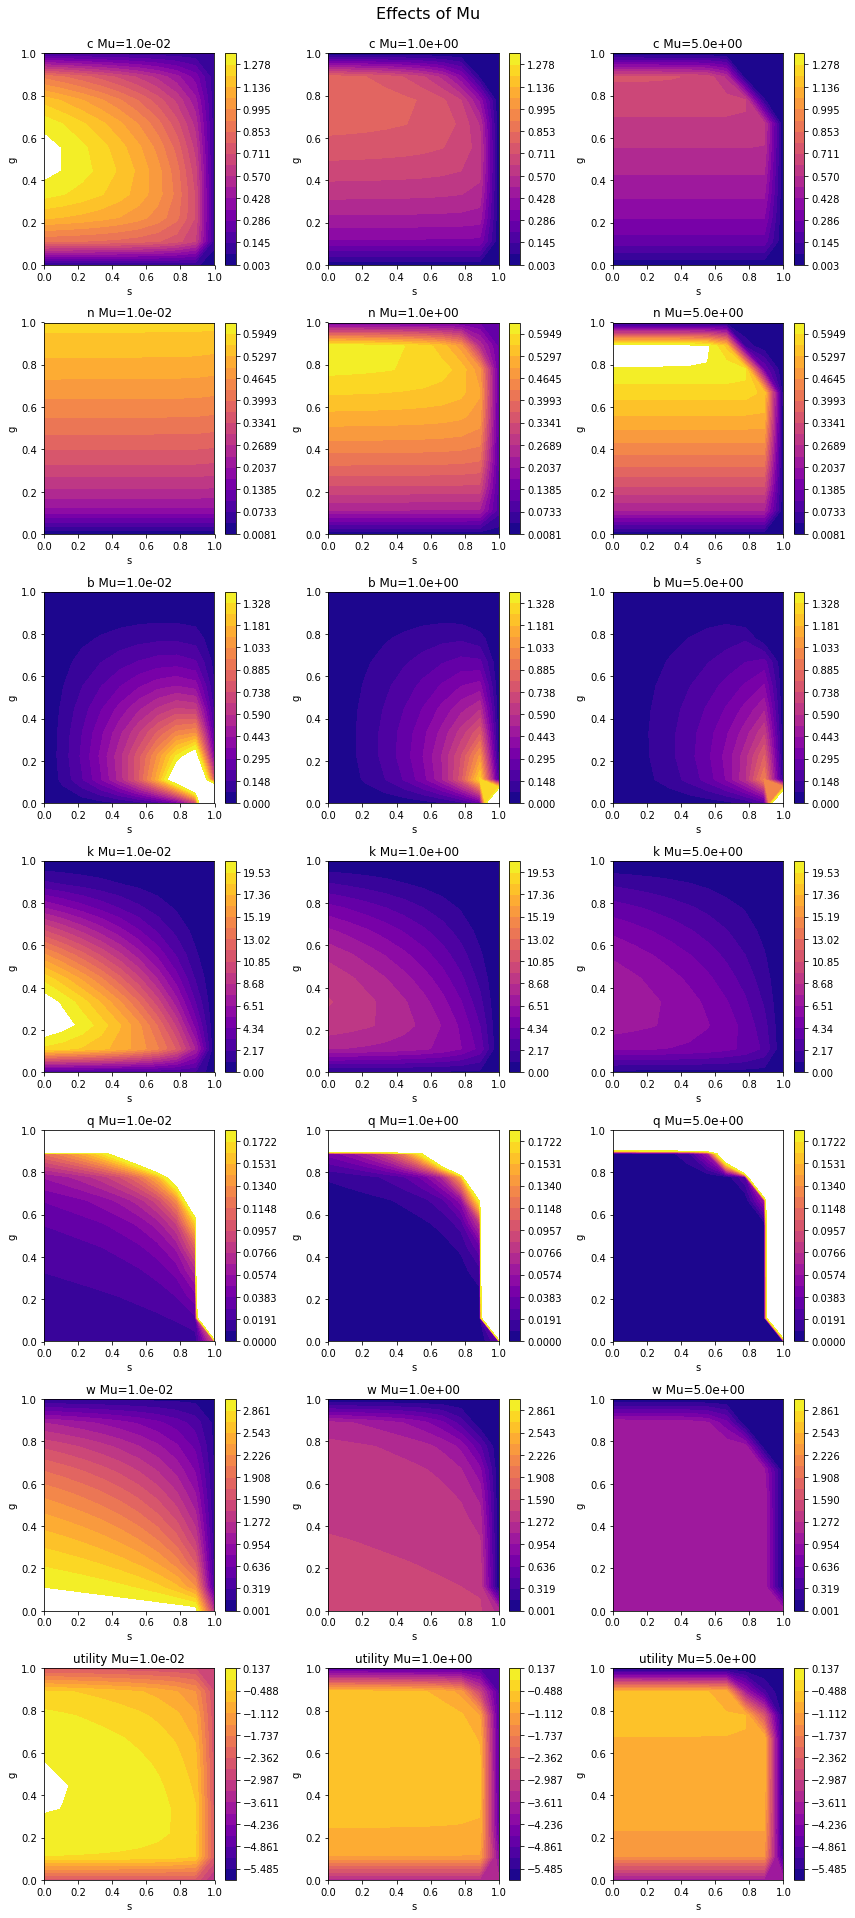

In [8]:
steadystate.plot_steady_state_effects(ss_mu, 'Mu', save='fig_steady_state_effects_rho.pdf', 
                                      sup_tit='Effects of Mu', n_lin = 20, 
                                      top_cutoff=0.9, q_cutoff=0.75, cmap = 'plasma')
plt.savefig('fig_heatmap_steady_state.pdf', bbox_inches='tight', format='pdf')

-----
# Analysis of Crises

In [9]:
def crisis_timing(indicator):
    ix = pd.Series(indicator) == 1
    crisis_end = np.flatnonzero((ix.shift(-1)==False) & (ix==True))[:,np.newaxis]
    crisis_start = np.flatnonzero((ix.shift(-1)==True) & (ix==False))[:crisis_end.shape[0],np.newaxis]
    df = pd.DataFrame(np.hstack([crisis_start, crisis_end]), columns=['start','end'])
    df.loc[:,'duration'] = df.end - df.start
    return df

In [14]:
def crisis_simulation(params, start_dict, s0_range = np.logspace(-1e-2,-1e-7,10), T = int(1e4)):
    
    # initial values
    assert start_dict['k']>start_dict['n'], "Can't start in a crisis"
    start = np.array([v for _,v in start_dict.items()])
    
    np.random.seed(10)
    
    # results setup
    results = {'Analysis':pd.DataFrame(index=s0_range, columns=['Proportion','Avg. Duration', 'Frequency'])}
    results['Simulation'] = {s0:None for s0 in s0_range}
    results['Crisis'] = {s0:None for s0 in s0_range}

    for s0 in s0_range:
        # Update parameters
        params['sentiment'] = s0
        # Simulate
        df = model.simulate(start, params, t_end=T)
        crisis_indicator = 0.5 * (1.0 + np.sign(df.n - df.k))
        crises = crisis_timing(crisis_indicator)
        stats = [crises.duration.sum() / T, crises.shape[0], crises.duration.mean()]
        # Save results
        results['Analysis'].loc[s0,:] = stats
        results['Simulation'][s0] = df
        results['Crisis'][s0] = crises
        
    return results

In [159]:
params = {'etaZ': 0.2, 'sigmaZ': 0.2, 'zbar': 10.0,
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.01, 
          's_min': 1e-6, 's_max': 1-1e-6,'s_theta':5.0, 'sentiment':0.99,
          'gamma': 1.0, 'alpha': 0.33, 'mu': 12.32}
start = dict(z=1, c=1, n=1, b=1, w=1, k=1.1, q=0.0, g=0.7, s=0.5, income=1, news=1, xiz=0, xin=0)

res = crisis_simulation(params, start, s0_range = [1.0,0.99,0.9,0.85,.8,.75,.7], T = int(1e6))

In [168]:
def inv_log_hist(ax, s, label, col):
    bins = np.logspace(-6,0,100)
    x = np.linspace(-14, 1 , 100)
    inv = np.histogram(1-s,bins=bins)
    m, q = np.polyfit(np.log(inv[1][71:]),np.log(inv[0][70:]), deg=1)
    ax.plot(np.log(inv[1][:-1]), np.log(inv[0]),'o', color = col)
    ax.plot(x , x*m+q,'--', color = col , label = r'fit = ' + str(np.round(m,2)))
def crisis_log_hist(ax, crisis, label, col): 
    
    x = np.linspace(0, 5 , 100)

    cris = np.histogram(crisis, bins=np.logspace(0,2,50))
    sel = np.log(cris[0])>0
    ax.plot(np.log(cris[1][:-1]),np.log(cris[0]), 'x', label = r"$\mathcal{S}=$"+"{:.3f}".format(label), color = col)

    if sum(sel)>2:
        m, q = np.polyfit(np.log(cris[1][:-1][sel]),np.log(cris[0][:][sel]), deg=1)
        ax.plot(x , x*m+q,'--', color = col )
def double_hist(c_sim):
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10,5)
    
    s0_list = c_sim[list(c_sim.keys())[1]].keys()
    
    for s0 in s0_list:
        col = (np.random.uniform(),np.random.uniform(),np.random.uniform())
        inv_log_hist(ax[0], c_sim['Simulation'][s0].s, s0, col)
        crisis_log_hist(ax[1], c_sim['Crisis'][s0].duration, s0, col)

    ax[0].set_title('Histogram of Investment Proportion')
    ax[0].set_xlabel(r'$\log$ (1-s)')
    ax[0].set_ylabel(r'$\log$ frequency')
    #ax[0].set_xscale('log')
    #ax[0].set_yscale('log')
    
    ax[1].set_title('Histogram of Crisis Duration')
    ax[1].set_xlabel(r'$\log$ Duration')
    ax[1].set_ylabel(r'$\log$ frequency')
    ax[1].legend()
    #ax[1].set_xscale('log')
    #ax[1].set_yscale('log')
    ax[0].legend()
    plt.tight_layout()
    plt.show()

/Users/fedemoro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/fedemoro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


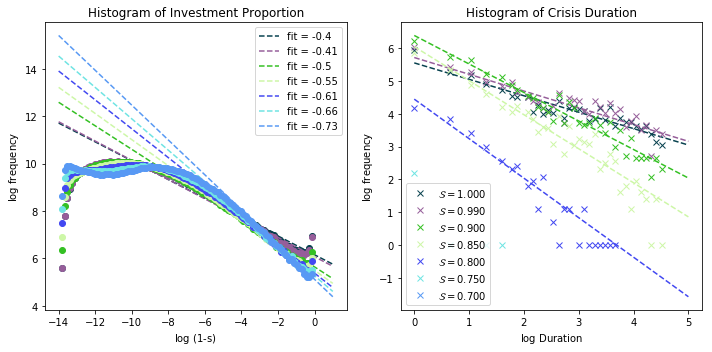

In [169]:
double_hist(res)

-----
# Step function experimentation

Only change this later on if we want to test new things

In [18]:
def step(t: float, x: np.ndarray, p: dict, err:float):
    """Iteration of one step in the simulation
    
    Parameters
    ----------
    t : float
        Current timestep t
    x : np.ndarray
        state variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, g_, s_, news_, inc_, xiz_, xin_ = x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
    
    # Observe "State of economy"
    g = g_
    signal = np.tanh(p['s_theta'] * (s_ - news_))
    s = 0.5 * ((p['s_max'] - p['s_min']) * signal + p['s_max'] + p['s_min'])

    # Determine Consumption
    c = model.bisection(z, g, k_, p)
    
    # Working hours via market clearing
    n = ((c / z) ** (-1 * p['mu']) - p['alpha'] * k_ ** (-1 * p['mu']))
    n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])
    
    # Firm observes desired working hours, sets the wage accordingly
    rho = -1 * p['mu']
    temp = (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (rho - 1))
    
    # Income
    income = w * n + (b_  + q_ * k_) / (1 + p['inflation'])
    
    # Investment & Bonds
    investment = income * (1 - g)
    b = (1 + p['interest']) * s * investment
    
    # Capital & Risky return
    k = (1 - p['depreciation']) * k_ + investment * (1 - s)
    q = p['alpha'] * z * temp * (k ** (rho - 1))
    
    # Signals to the household investor
    info_c = c / c_ - 1
    info_r = (q - p['interest']) / (q + p['interest'])
    news = p['s0'] * info_c + (1 - p['s0']) * info_r
    
    return z, c, n, b, w, k, q, g, s, news, income, xiz, 0

# TO CHANGE THE STEP DO NOT CHANGE THE RETURN VARIABLES

In [474]:
def step(t: float, x: np.ndarray, p: dict, err:float):
    """Iteration of one step in the simulation
    
    Parameters
    ----------
    t : float
        Current timestep t
    x : np.ndarray
        state variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, g_, s_, news_, inc_, xiz_, xin_= x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
    
    # Observe "State of economy"
    g = g_
    signal = np.tanh(p['s_theta'] * (s_ - news_))
    s = 0.5 * ((p['s_max'] - p['s_min']) * signal + p['s_max'] + p['s_min'])

    # Determine Consumption
    c = model.bisection(z, g, k_, p)
    
    # Working hours via market clearing
    n = ((c / z) ** (-1 * p['mu']) - p['alpha'] * k_ ** (-1 * p['mu']))
    n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])
    
    # Firm observes desired working hours, sets the wage accordingly
    rho = -1 * p['mu']
    temp = (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (rho - 1))
    
    # Income
    income = w * n + (b_  + q_ * k_) / (1 + p['inflation'])
    
    # Investment & Bonds
    investment = income * (1 - g)
    b = (1 + p['interest']) * s * investment
    
    # Capital & Risky return
    k = (1 - p['depreciation']) * k_ + (investment * (1 - s))
    q = p['alpha'] * z * temp * (k ** (rho - 1))
    
    # Signals to the household investor
    th_c = (0.1*c_)**(-1)
    th_r = (0.1*p['interest'])**(-1)
    info_c = p['sentiment'] * np.tanh(th_c*(c - c_))
    #info_r = (q - p['interest']) / (q + p['interest'])
    info_r = p['sentiment'] * np.tanh(th_r*(q- p['interest']))
    #print(info_c, ' ' , info_r)
    news = p['s0'] * info_c + (1 - p['s0']) * info_r
    
    return z, c, n, b, w, k, q, g, s, news, income, xiz, 0

# TO CHANGE THE STEP DO NOT CHANGE THE RETURN VARIABLES

----
## Interactive Analysis

/Users/fedemoro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


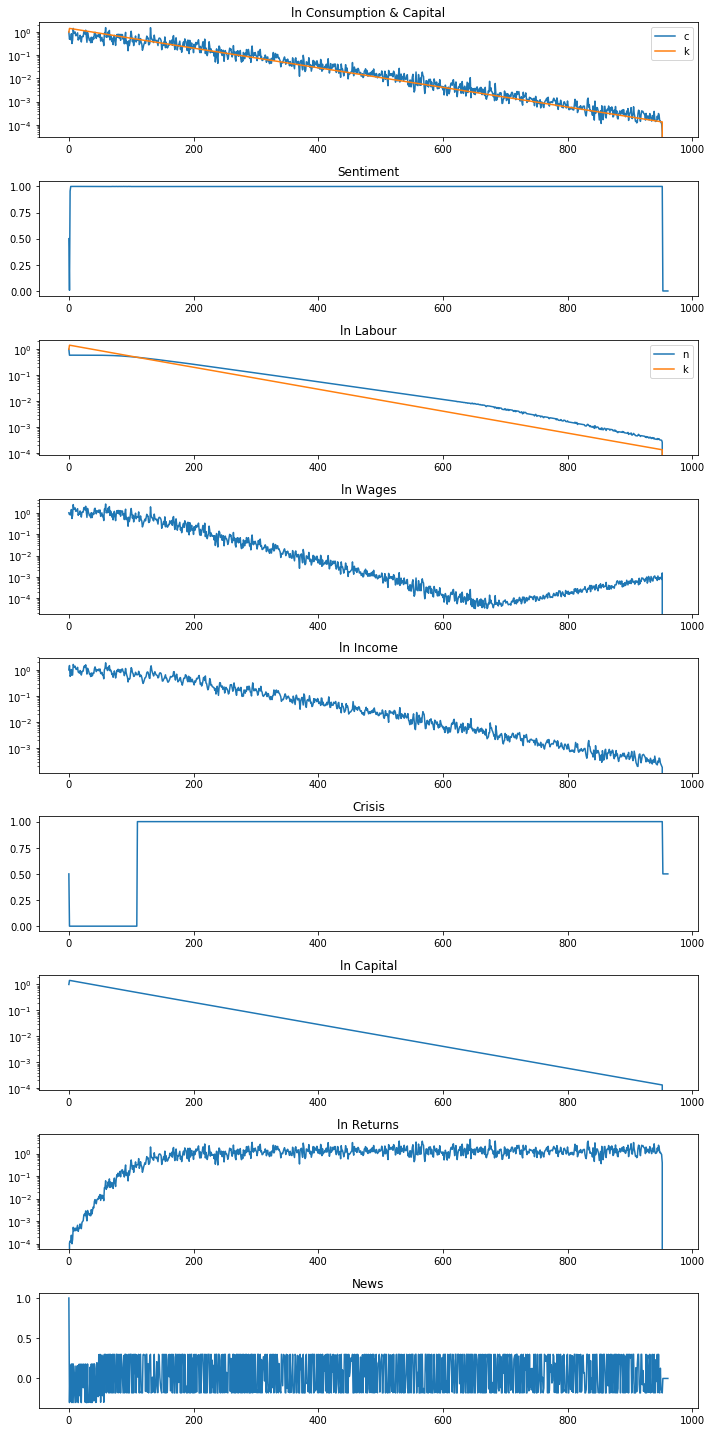

<Figure size 432x288 with 0 Axes>

In [475]:
params = {'etaZ': 0.2, 'sigmaZ': 0.4, 'zbar': 1.0,
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.01, 
          's_min': 1e-4, 's_max': 1-1e-4,'s_theta':5, 's0':.8, 'sentiment':.3,
          'gamma': 1.0, 'alpha': 0.33, 'mu': 8.32}

start = dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.0, g=0.7, s=0.5, income=1, news=1, xiz=0, xin=0)
start = np.array([v for _,v in start.items()])

T = 10000
np.random.seed(40)
view = (0,T)

df = model.simulate(start, params, step_func=step, t_end=T)

df.loc[:, 'crisis'] = 0.5 * (1.0 + np.sign(df.n - df.k))
df.loc[:, 'inv'] = 100 * (1-df.loc[:,'g'])
df.loc[:,'bc'] = df.b / df.c
df.loc[:,'utility'] = np.log(df.c) - params['gamma'] * (df.n ** 2)

df = df.iloc[view[0]:view[1],:]

graphs = {
        'ln Consumption & Capital' : [df.loc[:,['c','k']], True],
        'Sentiment' : [df.s, False],
        'ln Labour' : [df.loc[:,['n','k']], True],
        'ln Wages' : [df.w, True],
        'ln Income' : [df.income, True],
        'Crisis' : [df.crisis, False],
        'ln Capital' : [df.loc[:,['k']], True],
        'ln Returns' : [df.q, True],
        'News' : [df.news, False],
    }


axs = steadystate.simulation_graph(graphs, size = (10, 20), save='test.pdf')
axs['ln Returns'].axhline(params['interest'])
plt.show()

In [470]:
len(axs)

9

/Users/fedemoro/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/fedemoro/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


ValueError: max must be larger than min in range parameter.

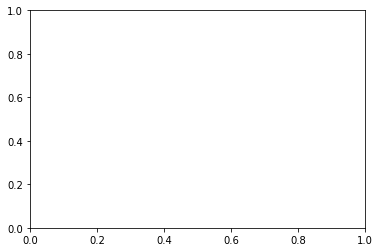

In [471]:
fig, ax = plt.subplots(1,1)
info_c = df.c.iloc[1:] / df.c.shift(-1) - 1
info_r = (df.q - params['interest']) / (df.q + params['interest'])
bins = 40
#ax.hist(df.news, bins = bins, label='N', alpha=0.5, color='black')
ax.hist(info_c, bins = bins, label='C', alpha=0.5)
ax.hist(info_r, bins = bins, label='R', alpha=0.5)
#ax.set_yscale('log')
ax.legend()
plt.show()


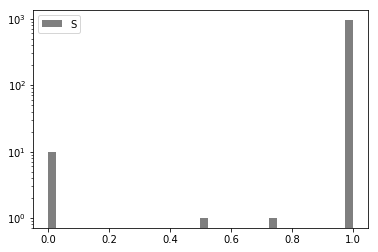

In [349]:
fig, ax = plt.subplots(1,1)
info_c = df.c.iloc[1:] / df.c.shift(-1) - 1
info_r = (df.q - params['interest']) / (df.q + params['interest'])
bins = 40
ax.hist(df.s, bins=40, label='S', alpha=0.5, color='black')
#ax.hist(df.news, bins = bins, label='N', alpha=0.5)
ax.set_yscale('log')
ax.legend()
plt.show()


(-1.05, 1.05)

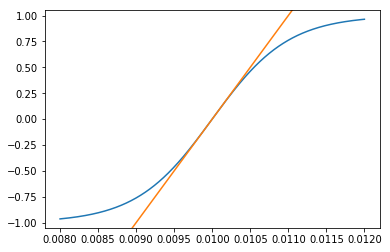

In [257]:
x = np.linspace(0.008,0.012,100000)
def f(x,r):
    th = (r*(0.1))**(-1)
    return np.tanh(th*(x-r)), th
plt.plot(x,f(x,0.01)[0])
plt.plot(x,(x-0.01)*f(x,0.01)[1])
plt.ylim([-1.05,1.05])
#plt.plot(np.ones(10)*0.01, np.linspace(-1,1,10))